<a href="https://colab.research.google.com/github/mteoraso/Energia_electrica_COL_XM/blob/EDA/demanda_no_atendida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydataxm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 14.5 MB/s eta 0:00:00
  Created wheel for pydataxm: filename=pydataxm-0.3.12-py3-none-any.whl size=13050 sha256=f87bb8e16af1a84f775ca1a456e05005a200b1ca56883eee6dba258e8fe22618
  Stored in directory: /root/.cache/pip/wheels/98/0e/34/8f4f853a19b48703369a032318a29282b5c5ad81a3cd1e1494
Successfully built pydataxm


In [102]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="bright")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  ## Autocorrelacion en series de tiempo
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA  ## Analisis de regresion en series de tiempo
from statsmodels.formula.api import ols ## ANOVA de dos o multiples vias con efectos aleatorios
from statsmodels.formula.api import mixedlm ## ANOVA de dos o multiples vias con efectos mixtos
from scipy.stats import chi2_contingency ## Analisis de correspondencia
from sklearn.model_selection import KFold ## Validacion cruzada
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
# Importación de API XM
from pydataxm.pydatasimem import ReadSIMEM, CatalogSIMEM

# Crear una instancia de ReadSIMEM
dataset_id = '3C77AF'
fecha_inicio = '2020-01-01'
fecha_fin = '2024-04-30'
generacion = ReadSIMEM(dataset_id, fecha_inicio, fecha_fin)

# Recuperar datos
data = generacion.main(filter=False)
print(data)

****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Eventos de Demanda No Atendida"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0008261203765869141
Extraccion de registros: 147.94177913665771
End of data extracting process
****************************************************************************************************
     IdentificadorSuceso  ... CodigoSubAreaOperativa
0             S000017905  ...                Are0025
1             S000017904  ...                Are0029
2             S000017903  ...                Are0018
3             S000017901  ...                Are0025
4             S000017902  ...                Are0016
...                  ...  ...                    ...
3585          S000022218  ...                Are0019
3586          S000022220  ...   

In [3]:
data

,IdentificadorSuceso,FechaHoraInicio,FechaHoraFin,OrigenEvento,EnergiaNoAtendida,DescripcionEvento,CodigoSubAreaOperativa
0,S000017905,2020-01-31 13:04:00,2020-01-31 19:59:00,No programada,151140.0,Demanda no atendida por disparo del activo SAN...,Are0025
1,S000017904,2020-01-29 09:43:00,2020-01-29 09:53:00,No programada,4630.0,Demanda no atendida por trabajos en la consign...,Are0029
2,S000017903,2020-01-27 14:24:00,2020-01-27 16:31:00,No programada,14610.0,Demanda no atendida por sobrecarga del activo ...,Are0018
3,S000017901,2020-01-26 07:24:00,2020-01-26 13:15:00,Programada,45100.0,Demanda no atendida por trabajos en la consign...,Are0025
4,S000017902,2020-01-26 05:16:00,2020-01-26 06:34:00,Programada,26650.0,Demanda no atendida por trabajos en la consign...,Are0016
...,...,...,...,...,...,...,...
3585,S000022218,2024-04-01 00:00:00,2024-04-01 00:38:00,No programada,1080.0,Continua demanda no atendida por disparo del a...,Are0019
3586,S000022220,2024-04-01 15:41:00,2024-04-01 15:44:00,No programada,1100.0,Demanda no atendida por disparo del activo BL1...,Are0015
3587,S000022217,2024-03-31 23:08:00,2024-03-31 23:59:00,No programada,1440.0,Demanda no atendida por disparo del activo BL1...,Are0019
3588,S000022327,2024-04-30 15:17:00,2024-04-30 15:30:00,No programada,2030.0,Demanda no atendida por disparo del activo LA ...,Are0015


# **Analisis Exploratorio de datos**

In [4]:
data.describe()

,EnergiaNoAtendida
count,3.590000e+03
mean,6.429359e+04
std,1.288574e+05
min,7.000000e+01
25%,3.960000e+03
50%,1.558500e+04
75%,7.000000e+04
max,2.608110e+06


In [5]:
data.shape

(3590, 7)

In [6]:
data.columns

Index(['IdentificadorSuceso', 'FechaHoraInicio', 'FechaHoraFin',
       'OrigenEvento', 'EnergiaNoAtendida', 'DescripcionEvento',
       'CodigoSubAreaOperativa'],
      dtype='object')

**Limpieza y transformacion de datos**

In [7]:
data.isnull().sum()

,0
IdentificadorSuceso,0
FechaHoraInicio,0
FechaHoraFin,0
OrigenEvento,0
EnergiaNoAtendida,0
DescripcionEvento,0
CodigoSubAreaOperativa,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3590 entries, 0 to 3589
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IdentificadorSuceso     3590 non-null   object 
 1   FechaHoraInicio         3590 non-null   object 
 2   FechaHoraFin            3590 non-null   object 
 3   OrigenEvento            3590 non-null   object 
 4   EnergiaNoAtendida       3590 non-null   float64
 5   DescripcionEvento       3590 non-null   object 
 6   CodigoSubAreaOperativa  3590 non-null   object 
dtypes: float64(1), object(6)
memory usage: 196.5+ KB


In [9]:
data = data.astype({"FechaHoraInicio": "datetime64[ns]"})
data = data.astype({"FechaHoraFin": "datetime64[ns]"})
data = data.astype({"OrigenEvento": "category"})
data = data.astype({"CodigoSubAreaOperativa": "category"})
data = data.astype({"IdentificadorSuceso": "category"})
data = data.astype({"DescripcionEvento": "category"})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3590 entries, 0 to 3589
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   IdentificadorSuceso     3590 non-null   category      
 1   FechaHoraInicio         3590 non-null   datetime64[ns]
 2   FechaHoraFin            3590 non-null   datetime64[ns]
 3   OrigenEvento            3590 non-null   category      
 4   EnergiaNoAtendida       3590 non-null   float64       
 5   DescripcionEvento       3590 non-null   category      
 6   CodigoSubAreaOperativa  3590 non-null   category      
dtypes: category(4), datetime64[ns](2), float64(1)
memory usage: 349.6 KB


In [10]:
## Identificacion de registros duplicados donde coinciden en todos los campos
DF_duplicados = data.duplicated()
print(f"El numero de registros duplicados es de: {DF_duplicados.sum()}")

El numero de registros duplicados es de: 0


In [11]:
DF_duplicados

,0
0,False
1,False
2,False
3,False
4,False
...,...
3585,False
3586,False
3587,False
3588,False


In [12]:
## Visualizo los registros unicos de cada campo
columnas_DF = data.columns
for i in columnas_DF:
  print(f"Valores unicos en la columna {i}:")  ## Nombro la columna a mostrar
  print(pd.unique(data[i]))  ## Imprimo los valores unicos de cada columna

Valores unicos en la columna IdentificadorSuceso:
['S000017905', 'S000017904', 'S000017903', 'S000017901', 'S000017902', ..., 'S000022218', 'S000022220', 'S000022217', 'S000022327', 'S000022328']
Length: 3589
Categories (3589, object): ['S000017857', 'S000017858', 'S000017859', 'S000017860', ..., 'S000022325',
                            'S000022326', 'S000022327', 'S000022328']
Valores unicos en la columna FechaHoraInicio:
['2020-01-31T13:04:00.000000000' '2020-01-29T09:43:00.000000000'
 '2020-01-27T14:24:00.000000000' ... '2024-03-31T23:08:00.000000000'
 '2024-04-30T15:17:00.000000000' '2024-04-30T14:57:00.000000000']
Valores unicos en la columna FechaHoraFin:
['2020-01-31T19:59:00.000000000' '2020-01-29T09:53:00.000000000'
 '2020-01-27T16:31:00.000000000' ... '2024-03-31T23:59:00.000000000'
 '2024-04-30T15:30:00.000000000' '2024-04-30T18:32:00.000000000']
Valores unicos en la columna OrigenEvento:
['No programada', 'Programada']
Categories (2, object): ['No programada', 'Programada'

In [13]:
descripciones_eventos = pd.unique(data['DescripcionEvento'])
descripciones_eventos

['Demanda no atendida por disparo del activo SA..., 'Demanda no atendida por trabajos en la consig..., 'Demanda no atendida por sobrecarga del activo..., 'Demanda no atendida por trabajos en la consig..., 'Demanda no atendida por trabajos en la consig..., ..., 'Demanda no atendida por disparo del activo BT..., 'Continua demanda no atendida por disparo del ..., 'Demanda no atendida por disparo del activo BL..., 'Demanda no atendida por disparo del activo BL..., 'Demanda no atendida por disparo del activo ES...]
Length: 2802
Categories (2802, object): [' Demanda no atendida  del activo ALTAMIRA - P..., ' Demanda no atendida  del activo BL1 EL PASO ...,
                            ' Demanda no atendida  del activo BL1 JARDINER..., ' Demanda no atendida  del activo GRANADA - OC...,
                            ..., 'Se presenta DNA no contemplada en los trabajo...,
                            'Se presenta DNA por evento en las subáreas At..., 'no atendida por trabajos en la consignación C..

In [14]:
len(descripciones_eventos)

2802

**Identificacion de patrones y relaciones entre campos**

In [15]:
## Cantidad de eventos por categoria (Programados y no programados)
DF_origen_evento = data.groupby(['OrigenEvento']).size()
DF_origen_evento

<ipython-input-15-633231647c74>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DF_origen_evento = data.groupby(['OrigenEvento']).size()


,0
OrigenEvento,
No programada,2626
Programada,964


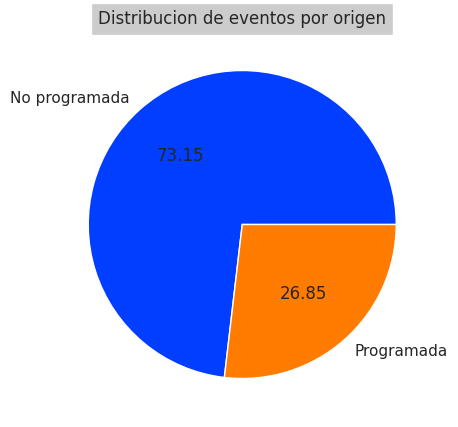

In [16]:
DF_origen_evento_plot = DF_origen_evento.plot.pie(
    figsize=(5, 5),
    autopct="%.2f")
plt.title("Distribucion de eventos por origen", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [17]:
## Cantidad de energia no atendida por origen de evento
DF_origen_cant = data.groupby('OrigenEvento')['EnergiaNoAtendida'].sum().round(20).sort_values(ascending=False)
DF_origen_cant

<ipython-input-17-79e38c796985>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DF_origen_cant = data.groupby('OrigenEvento')['EnergiaNoAtendida'].sum().round(20).sort_values(ascending=False)


,EnergiaNoAtendida
OrigenEvento,
Programada,1.424111e+08
No programada,8.840288e+07


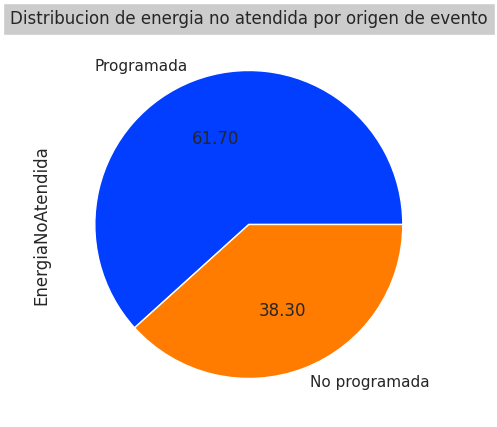

In [18]:
accidentes_sexo_plot = DF_origen_cant.plot.pie(
    figsize=(5, 5),
    autopct="%.2f")
plt.title("Distribucion de energia no atendida por origen de evento", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

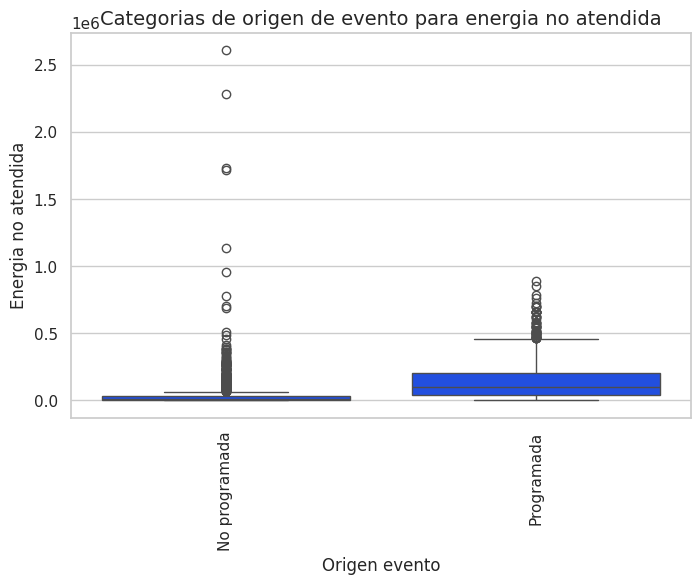

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data['OrigenEvento'], y=data['EnergiaNoAtendida'])
plt.title('Categorias de origen de evento para energia no atendida', fontsize=14)
plt.xlabel('Origen evento', fontsize=12)
plt.ylabel('Energia no atendida', fontsize=12)
plt.xticks(rotation=90)
plt.show()

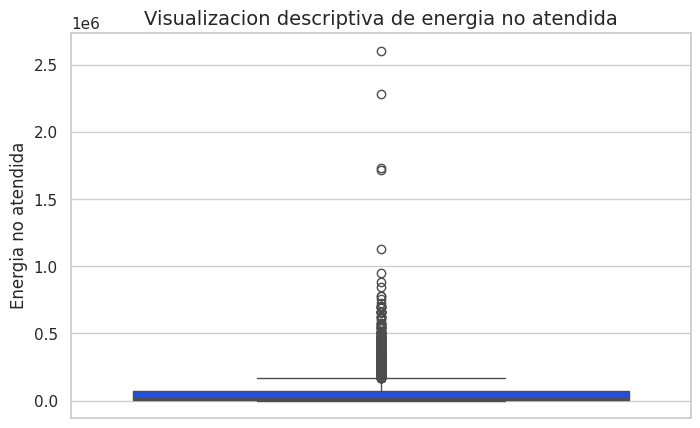

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(y=data['EnergiaNoAtendida'])
plt.title('Visualizacion descriptiva de energia no atendida', fontsize=14)
plt.ylabel('Energia no atendida', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [21]:
## Identificacion de energia no atendida por descripcion de evento
data.groupby('DescripcionEvento')['EnergiaNoAtendida'].sum().sort_values(ascending=False)

<ipython-input-21-ad45bb70b7f6>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('DescripcionEvento')['EnergiaNoAtendida'].sum().sort_values(ascending=False)


,EnergiaNoAtendida
DescripcionEvento,
Se presenta DNA por evento en las subáreas Atlántico Bolívar y GCM pertenecientes al área Caribe. Debido a falla en el CT de la fase A del activo BL2 SABANALARGA A FUNDACION 220 kV adicionalmente se disparan los extremos remotos asociados a los circuitos de la subestación SABANALARGA 220 kV.,6625350.00
Continua demanda no atendida por trabajos en la consignación de emergencia C0196936 del activo SAMORE - TOLEDO 1 230 kV dejando sin tensión las subestaciones radiales SAMORE 230 kV BANADIA 230 kV y CAÑO LIMON 230 kV.,3802000.00
Continua demanda no atendida por trabajos en la consignación de emergencia C0196936 del activo SAMORE - TOLEDO 1 230 kV dejando sin tensión las subestaciones radiales SAMORE 230 kV BANADIA 230 kV y CAÑO LIMON 230 kV.,2664050.00
Continua demanda no atendida por evento en la S/E VALLEDUPAR 220 KV -110 KV-34.5 KV- 13.8 KV.,1887370.02
"Continúa demanda no atendida por disparo de los activos asociados a la barra CHINÚ 110 KV y el transformador CHINÚ 1 150 MVA 500/110/34.5 kV; dejando sin tensión las subestaciones: CHINÚ PLANTA 110 kV, SAN MARCOS (SUCRE) 110 kV, LA MOJANA 110 kV, CHINÚ PLANTA 110 kV, SINCÉ 110 kV, MAGANGUÉ 110 kV, MOMPOX 110 kV, BOSTON 110 kV, COVEÑAS 110 kV, SIERRA FLOR 110 kV, TOLUVIEJO 110 kV, EL CARMEN 110 kV, ZAMBRANO 66 kV, SAN JACINTO 66 kV y CALAMAR 66 kV.",1717050.00
...,...
Demanda no atendida por disparo de los activos asociados a la subestación CONVENCION 115 kV dejando sin tensión las subestaciones temporalmente radiales CONVENCION 115 kV y TIBU 115 kV.,1000.00
"Continúa demanda no atendida por disparo del activo BL1 EL PASO A EL BANCO 110 kV, dejando sin tensión la S/E radial EL BANCO 110 kV.",1000.00
Continua demanda no atendida por criterios de confiabilidad de la subárea Bolivar.,1000.00


In [22]:
## Identificacion de energia no atendida y cantidad de eventos por subarea operativa
DF_subarea = data.groupby('CodigoSubAreaOperativa').agg(
    TotalEnergiaNoAtendida=('EnergiaNoAtendida', 'sum'),
    CantidadRegistros=('CodigoSubAreaOperativa', 'size'),
).reset_index()

DF_subarea = DF_subarea.sort_values(by=['TotalEnergiaNoAtendida'], ascending=False)  ## Ordeno valores por cantidad de energia no atendida
DF_subarea['EnergiaNoAtendidaPorRegistro'] = round(DF_subarea['TotalEnergiaNoAtendida'] / DF_subarea['CantidadRegistros'], 4)

# Muestra el nuevo DataFrame
DF_subarea

<ipython-input-22-b40a343b483c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DF_subarea = data.groupby('CodigoSubAreaOperativa').agg(


,CodigoSubAreaOperativa,TotalEnergiaNoAtendida,CantidadRegistros,EnergiaNoAtendidaPorRegistro
8,Are0025,61339430.00,768,79869.0495
3,Are0018,46415029.97,654,70970.9938
1,Are0016,34914180.02,261,133770.8047
6,Are0021,25062750.02,327,76644.4955
4,Are0019,12860440.00,349,36849.3983
15,Are0129,10426030.00,57,182912.8070
2,Are0017,7099660.00,142,49997.6056
10,Are0027,7099239.99,167,42510.4191
9,Are0026,6678540.00,92,72592.8261
18,Are0132,4208450.00,114,36916.2281


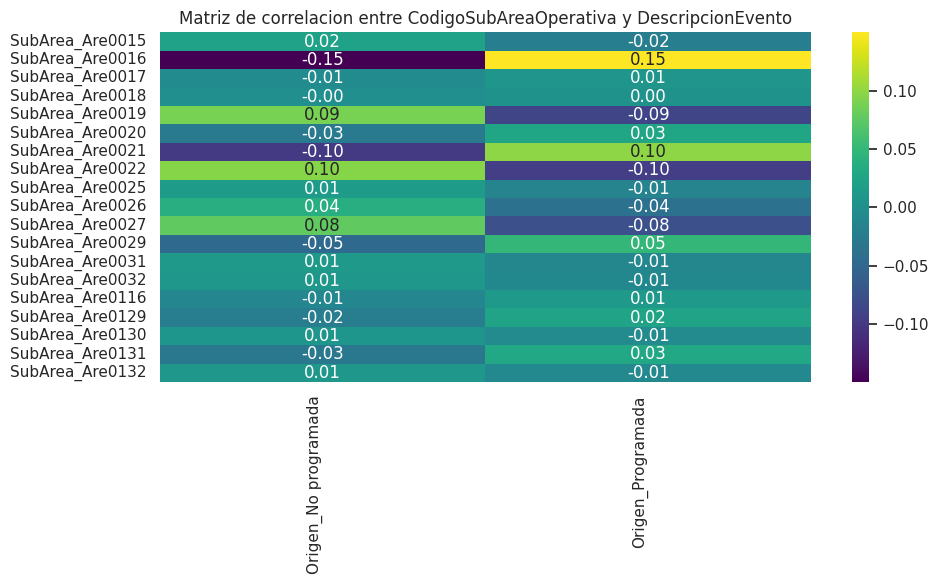

In [23]:
## Matriz de correlacion con respecto a origen Evento
# Creacion de DF
df_corr = data[['CodigoSubAreaOperativa', 'OrigenEvento']]

# Conversion en variables Dummy para colunas con variables categoricas
df_corr_dummy = pd.get_dummies(df_corr,
                               columns=['CodigoSubAreaOperativa', 'OrigenEvento'],
                               prefix=['SubArea', 'Origen'])

# Calculo de matriz de correlacion entre variables convertidas
corr = df_corr_dummy.corr()

# Reordeno para que en el eje X me quede el campo de origen Evento, y en el eje Y el codigo Subarea
subarea_cols = [col for col in corr.columns if col.startswith('SubArea')]
origen_cols = [col for col in corr.columns if col.startswith('Origen')]
corr_selected = corr.loc[subarea_cols, origen_cols]

# Creo el mapa de calor
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.heatmap(corr_selected, cmap="viridis", annot=True, fmt=".2f")  # Uso '.2f' para mostrar dos decimales en grafica
plt.title('Matriz de correlacion entre CodigoSubAreaOperativa y DescripcionEvento')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

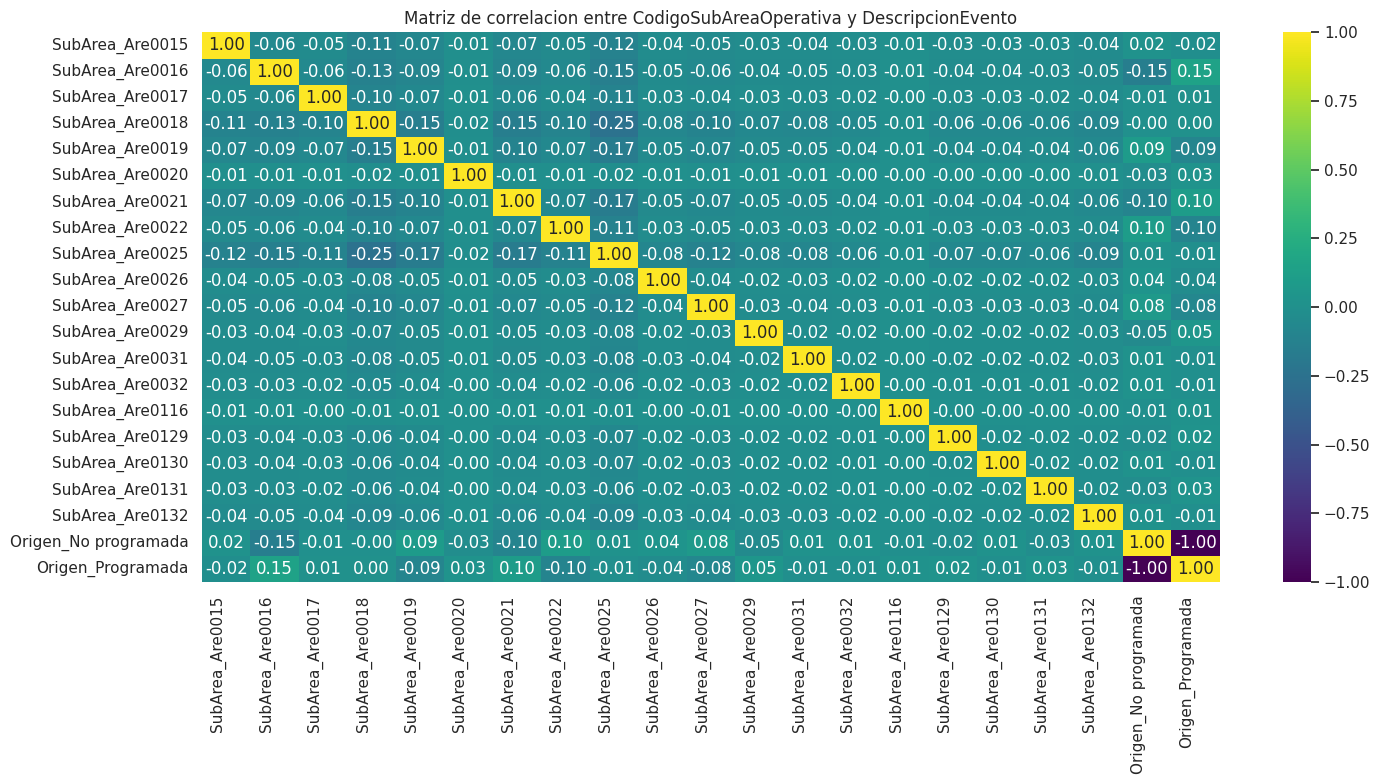

In [25]:
## Matriz de correlacion con respecto a subarea operativa

# Creo el mapa de calor
plt.figure(figsize=(15, 8))  # Adjust figure size if needed
sns.heatmap(corr, cmap="viridis", annot=True, fmt=".2f")  # Uso '.2f' para mostrar dos decimales en grafica
plt.title('Matriz de correlacion entre CodigoSubAreaOperativa y DescripcionEvento')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

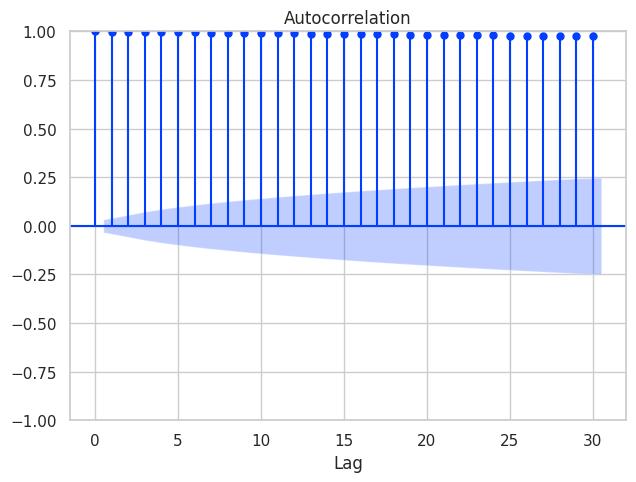

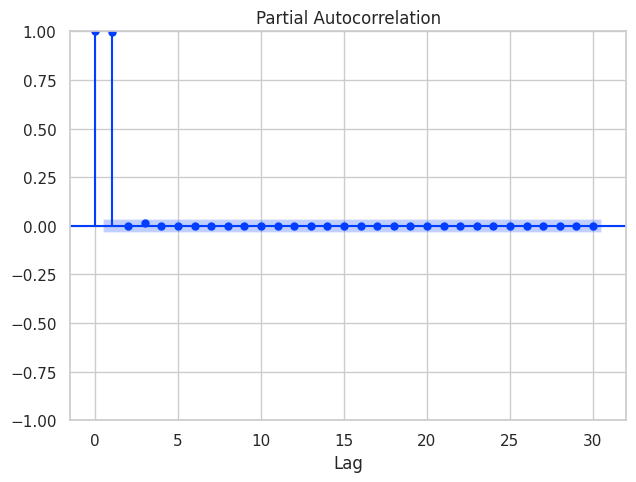

In [112]:
## Autocorrelacion con fecha y hora de inicio del evento
plot_acf(data['FechaHoraInicio'], lags=30)
plt.xlabel('Lag')
plt.show()

## Autocorrelacion parcial con fecha y hora de inicio del evento
plot_pacf(data['FechaHoraInicio'], lags=30)
plt.xlabel('Lag')
plt.show()

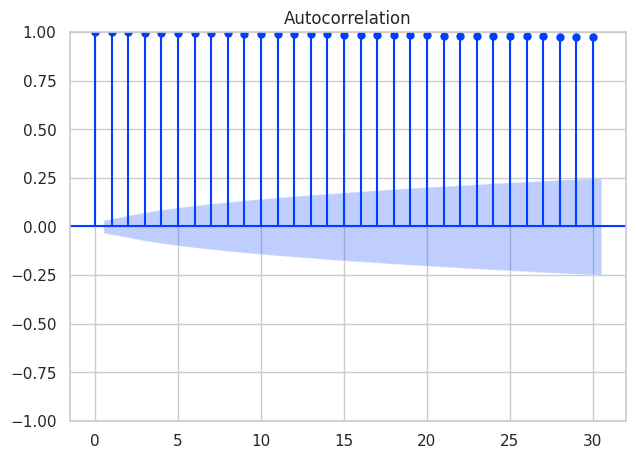

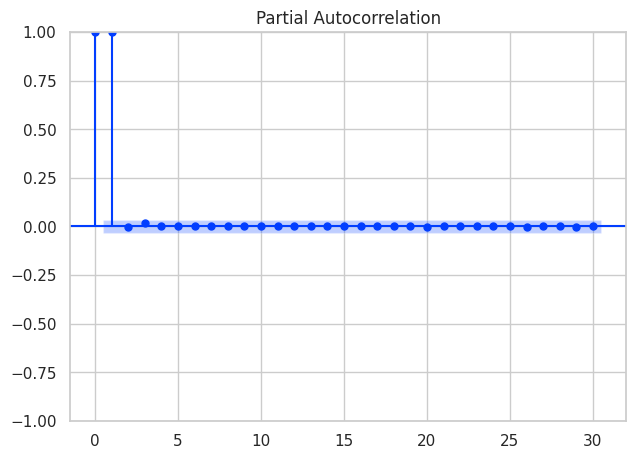

In [109]:
## Autocorrelacion con fecha y hora de fin del evento
plot_acf(data['FechaHoraFin'], lags=30)  # Adjust lags as needed
plt.show()

## Autocorrelacion parcial con fecha y hora de fin del evento
plot_pacf(data['FechaHoraFin'], lags=30)  # Adjust lags as needed
plt.show()

In [28]:
data_origen_desc = data.groupby(['OrigenEvento', 'DescripcionEvento']).size().sort_values(ascending=False)
data_origen_desc

<ipython-input-28-b3b345306f1f>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_origen_desc = data.groupby(['OrigenEvento', 'DescripcionEvento']).size().sort_values(ascending=False)


OrigenEvento   DescripcionEvento                                                                                                                                          
No programada  Demanda no atendida por bajas tensiones en la subestación EL BANCO 110 kV.                                                                                     33
               Demanda no atendida por disparo del activo GRANADA - OCOA 1 115 kV, dejando sin tensión las S/Es radiales GRANADA 115 kV y SAN JOSE DEL GUAVIARE 115 kV.       21
               Demanda no atendida por disparo del activo EL PASO - EL BANCO 1 110 kV dejando sin tensión la S/E radial EL BANCO 110 kV.                                      19
               Demanda no atendida por disparo del activo FUNDACION - TFUNDACION - RIO CORDOBA 1 110 kV.                                                                      17
               Demanda no atendida por disparo del activo EL PASO - EL COPEY 1 110 kV, dejando sin tensión las S/Es radiales EL PASO 110 kV y EL BANCO 110 kV.                13
                                                                                                                                                                              ..
Programada     Demanda no atendida por apertura de emergencia del activo CERROMATOSO - PLANETA RICA 110 kV, dejando sin tensión la subestación radial PLANETA RICA 110 kV.     0
               Demanda no atendida por apertura de emergencia del activo LA JAGUA - CODAZZI 110 kV, dejando sin tensión la subestación radial LA JAGUA 110 kV.                 0
               Demanda no atendida por apertura de emergencia del activo LN 591 COPEY 34.5 kV . El agente reporta falla en el SDL por punto caliente.                          0
               Demanda no atendida por apertura de emergencia del activo MAGDALENA - UNION (ATLANTICO) 1 34.5 kV.                                                              0
                Demanda no atendida  del activo ALTAMIRA - PITALITO 1 115 kV dejando sin tensión la S/E radial PITALITO 115 kV.                                                0
Length: 5604, dtype: int64

In [29]:
# Crea un diccionario para mapear las categorías a valores numéricos
mapeo_categorias = {categoria: valor for valor, categoria in enumerate(data['DescripcionEvento'].unique())}

# Aplica el mapeo a la columna 'DescripcionEvento'
data['DescripcionEvento_Numerica'] = data['DescripcionEvento'].map(mapeo_categorias)

# Imprime el DataFrame actualizado para verificar los cambios
data

,IdentificadorSuceso,FechaHoraInicio,FechaHoraFin,OrigenEvento,EnergiaNoAtendida,DescripcionEvento,CodigoSubAreaOperativa,DescripcionEvento_Numerica
0,S000017905,2020-01-31 13:04:00,2020-01-31 19:59:00,No programada,151140.0,Demanda no atendida por disparo del activo SAN...,Are0025,0
1,S000017904,2020-01-29 09:43:00,2020-01-29 09:53:00,No programada,4630.0,Demanda no atendida por trabajos en la consign...,Are0029,1
2,S000017903,2020-01-27 14:24:00,2020-01-27 16:31:00,No programada,14610.0,Demanda no atendida por sobrecarga del activo ...,Are0018,2
3,S000017901,2020-01-26 07:24:00,2020-01-26 13:15:00,Programada,45100.0,Demanda no atendida por trabajos en la consign...,Are0025,3
4,S000017902,2020-01-26 05:16:00,2020-01-26 06:34:00,Programada,26650.0,Demanda no atendida por trabajos en la consign...,Are0016,4
...,...,...,...,...,...,...,...,...
3585,S000022218,2024-04-01 00:00:00,2024-04-01 00:38:00,No programada,1080.0,Continua demanda no atendida por disparo del a...,Are0019,2798
3586,S000022220,2024-04-01 15:41:00,2024-04-01 15:44:00,No programada,1100.0,Demanda no atendida por disparo del activo BL1...,Are0015,2799
3587,S000022217,2024-03-31 23:08:00,2024-03-31 23:59:00,No programada,1440.0,Demanda no atendida por disparo del activo BL1...,Are0019,2800
3588,S000022327,2024-04-30 15:17:00,2024-04-30 15:30:00,No programada,2030.0,Demanda no atendida por disparo del activo LA ...,Are0015,2775


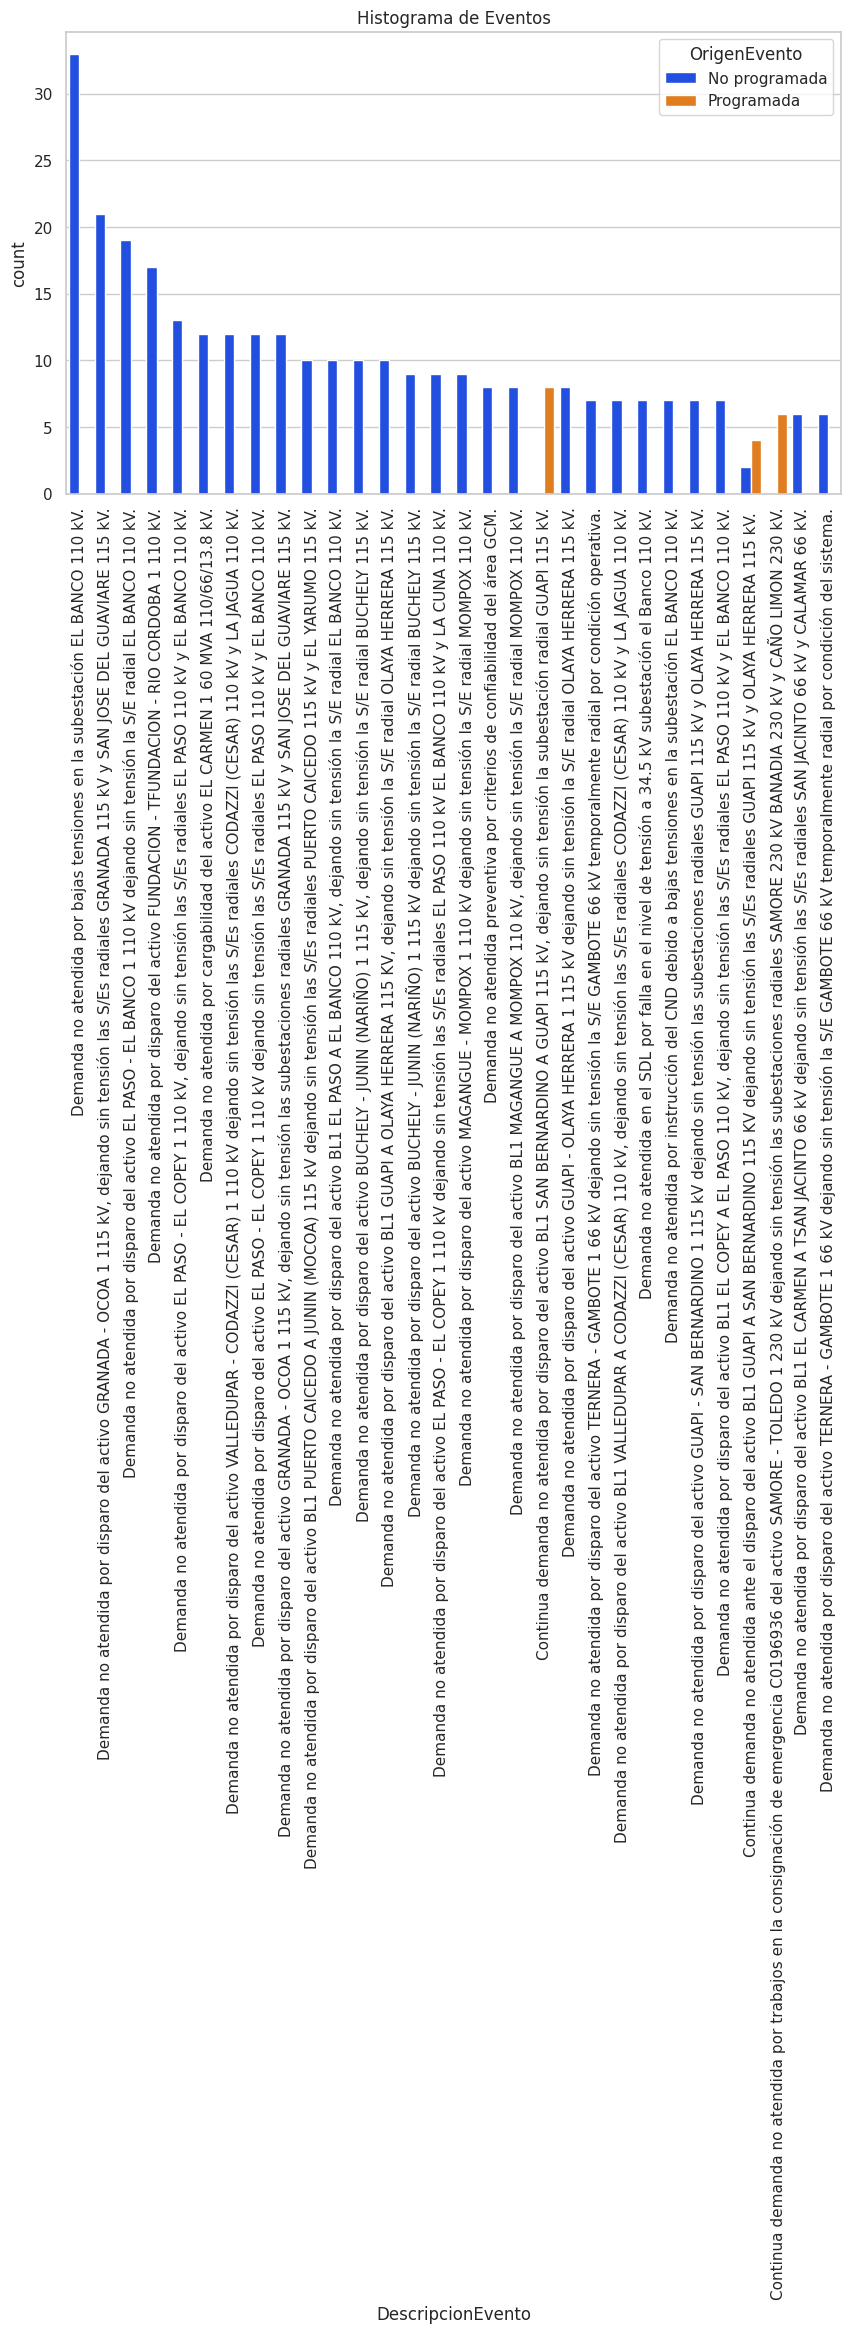

In [30]:
category_counts = data['DescripcionEvento'].value_counts()
category_order = category_counts.index
top_30_categories = category_counts.head(30).index
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario
sns.countplot(data=data, x="DescripcionEvento", hue="OrigenEvento", order=top_30_categories)
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para mejor legibilidad
plt.title('Histograma de Eventos')
plt.show()

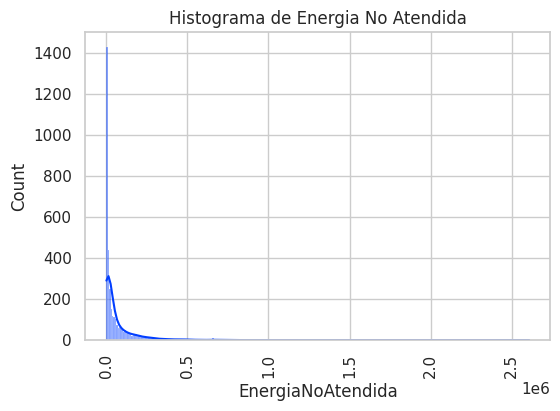

In [31]:
plt.figure(figsize=(6, 4))  # Ajusta el tamaño de la figura si es necesario
sns.histplot(data=data, x="EnergiaNoAtendida", kde=True)
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para mejor legibilidad
plt.title('Histograma de Energia No Atendida')
plt.show()

**Conclusiones**

In [38]:
## Sumatoria de registros
print(f"El total de energia no atendida desde 2020-01-31 hasta 2024-04-30, fue de {data['EnergiaNoAtendida'].sum()} kWh en una duracion de {round(data['DuracionDias'].sum(),4)} dias, correspondiente a {round(data['DuracionHoras'].sum(), 4)} horas")

El total de energia no atendida desde 2020-01-31 hasta 2024-04-30, fue de 230814000.0 kWh en una duracion de 650.7444 dias, correspondiente a 15617.8667 horas


**Analisis de serie de tiempo**

In [33]:
## Analisis temporal de eventos
data['DuracionSegundos'] = (data['FechaHoraFin'] - data['FechaHoraInicio']).dt.total_seconds()
data['DuracionSegundos'].sort_values(ascending=False)

,DuracionSegundos
2556,142260.0
3479,127680.0
2204,111180.0
2909,106200.0
3395,104820.0
...,...
2206,120.0
3531,60.0
1447,0.0
1125,0.0


In [34]:
data['Duracion'] = (data['FechaHoraFin'] - data['FechaHoraInicio'])
data['DuracionHoras'] = data['Duracion'].dt.total_seconds() / 3600
data['DuracionHoras'].sort_values(ascending=False)

,DuracionHoras
2556,39.516667
3479,35.466667
2204,30.883333
2909,29.500000
3395,29.116667
...,...
2206,0.033333
3531,0.016667
1447,0.000000
1125,0.000000


In [35]:
data['DuracionDias'] = data['Duracion'].dt.total_seconds() / (3600*24)
data['DuracionDias'].sort_values(ascending=False)

,DuracionDias
2556,1.646528
3479,1.477778
2204,1.286806
2909,1.229167
3395,1.213194
...,...
2206,0.001389
3531,0.000694
1447,0.000000
1125,0.000000


In [36]:
## Estadisticos descriptivos
print(f"La duracion promedio  de los eventos en horas fue de: {round(data['DuracionHoras'].mean(), 5)}")
print(f"La mediana de la duracion de los eventos en horas fue de: {round(data['DuracionHoras'].median(), 5)}")
print(f"La desviacion estandar de los eventos en horas fue de: {round(data['DuracionHoras'].std(), 5)}")

La duracion promedio  de los eventos en horas fue de: 4.35038
La mediana de la duracion de los eventos en horas fue de: 1.65833
La desviacion estandar de los eventos en horas fue de: 5.5016


In [37]:
## Calculo percentiles
print("Percentiles para duracion de eventos en horas")
print(f"El percentil 25% es igual a {data['DuracionHoras'].quantile(q=0.25)}")
print(f"El percentil 50% es igual a {round(data['DuracionHoras'].quantile(q=0.5), 5)}")
print(f"El percentil 75% es igual a {round(data['DuracionHoras'].quantile(q=0.75), 5)}")

Percentiles para duracion de eventos en horas
El percentil 25% es igual a 0.3
El percentil 50% es igual a 1.65833
El percentil 75% es igual a 7.61667


# **Construccion de modelo predictivo**

**Ingenieria de caracteristicas**

In [42]:
X=data.drop(['OrigenEvento'], axis=1)
X

,IdentificadorSuceso,FechaHoraInicio,FechaHoraFin,EnergiaNoAtendida,DescripcionEvento,CodigoSubAreaOperativa,DescripcionEvento_Numerica,DuracionSegundos,Duracion,DuracionHoras,DuracionDias
0,S000017905,2020-01-31 13:04:00,2020-01-31 19:59:00,151140.0,Demanda no atendida por disparo del activo SAN...,Are0025,0,24900.0,0 days 06:55:00,6.916667,0.288194
1,S000017904,2020-01-29 09:43:00,2020-01-29 09:53:00,4630.0,Demanda no atendida por trabajos en la consign...,Are0029,1,600.0,0 days 00:10:00,0.166667,0.006944
2,S000017903,2020-01-27 14:24:00,2020-01-27 16:31:00,14610.0,Demanda no atendida por sobrecarga del activo ...,Are0018,2,7620.0,0 days 02:07:00,2.116667,0.088194
3,S000017901,2020-01-26 07:24:00,2020-01-26 13:15:00,45100.0,Demanda no atendida por trabajos en la consign...,Are0025,3,21060.0,0 days 05:51:00,5.850000,0.243750
4,S000017902,2020-01-26 05:16:00,2020-01-26 06:34:00,26650.0,Demanda no atendida por trabajos en la consign...,Are0016,4,4680.0,0 days 01:18:00,1.300000,0.054167
...,...,...,...,...,...,...,...,...,...,...,...
3585,S000022218,2024-04-01 00:00:00,2024-04-01 00:38:00,1080.0,Continua demanda no atendida por disparo del a...,Are0019,2798,2280.0,0 days 00:38:00,0.633333,0.026389
3586,S000022220,2024-04-01 15:41:00,2024-04-01 15:44:00,1100.0,Demanda no atendida por disparo del activo BL1...,Are0015,2799,180.0,0 days 00:03:00,0.050000,0.002083
3587,S000022217,2024-03-31 23:08:00,2024-03-31 23:59:00,1440.0,Demanda no atendida por disparo del activo BL1...,Are0019,2800,3060.0,0 days 00:51:00,0.850000,0.035417
3588,S000022327,2024-04-30 15:17:00,2024-04-30 15:30:00,2030.0,Demanda no atendida por disparo del activo LA ...,Are0015,2775,780.0,0 days 00:13:00,0.216667,0.009028


In [40]:
Y=data['OrigenEvento']
Y

,OrigenEvento
0,No programada
1,No programada
2,No programada
3,Programada
4,Programada
...,...
3585,No programada
3586,No programada
3587,No programada
3588,No programada


In [45]:
# Crear un objeto LabelEncoder
le = LabelEncoder()

# Ajustar la variable objetivo
Y_encoded = le.fit_transform(Y)

# Solo seleccionar caracteristicas numerical, excluyendo columna Timedelta
X_numerical = X.select_dtypes(include=np.number).drop(columns=['Duracion', 'DuracionSegundos'], errors='ignore')

# Calcula puntaje de informacion mutua
mi_scores = mutual_info_regression(X_numerical, Y_encoded)

# Create a pandas Series for better readability
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_numerical.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

DuracionHoras        0.230944
DuracionDias         0.228133
EnergiaNoAtendida    0.178441
Name: MI Scores, dtype: float64
